## Setup

In [5]:
# Libraries
import sklearn
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
import cv2
from google.colab.patches import cv2_imshow

# Seeds
np.random.seed(42)
tf.random.set_seed(42)

# Plotting
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [6]:
from google.colab import drive
drive.mount('/content/drive/', force_remount = True)
project_root_dir = '/content/drive/My Drive/CS_229_project/'

Mounted at /content/drive/


In [7]:
img_dir = os.path.join(project_root_dir, 'img_data')
aqi_dir = os.path.join(project_root_dir, 'aqi_data', 'final_data')
experiments_dir = os.path.join(project_root_dir, 'experiments')

## Load Labels


In [59]:
label_file = pd.read_csv("/content/drive/My Drive/CS_229_project/aqi_data/final_data/label_file.csv")
label_file.head()

,Unnamed: 0,id,file,site,strip_id,cloud_cover,Site_ID,src_directory,filenames,Date,ozone_AQI,pm2.5_AQI,AQI,class,pm2.5_class,AQI_class,pm2.5_AQI_class,set
0,0,59_5001,20190902_184228_93_1067,5001.0,2646834.0,0.18,60595001,county_site,59_5001_20190902_184228_93_1067_3B_Visual_clip...,2019-09-02,37.0,0.0,37.0,0,NaN,Good,NaN,valid
1,1,59_5001,20181007_180623_1005,5001.0,1751570.0,0.19,60595001,county_site,59_5001_20181007_180623_1005_3B_Visual_clip.jpg,2018-10-07,42.0,0.0,42.0,0,NaN,Good,NaN,train
2,2,59_5001,20200517_182913_87_1067,5001.0,3405714.0,0.12,60595001,county_site,59_5001_20200517_182913_87_1067_3B_Visual_clip...,2020-05-17,40.0,0.0,40.0,0,NaN,Good,NaN,test
3,3,59_5001,20180406_180052_0f1b,5001.0,1332476.0,0.15,60595001,county_site,59_5001_20180406_180052_0f1b_3B_Visual_clip.jpg,2018-04-06,43.0,0.0,43.0,0,NaN,Good,NaN,train
4,4,59_5001,20200205_183444_42_1064,5001.0,3107865.0,0.22,60595001,county_site,59_5001_20200205_183444_42_1064_3B_Visual_clip...,2020-02-05,28.0,0.0,28.0,0,NaN,Good,NaN,train


In [60]:
label_file.loc[label_file["AQI_class"].isin(["Unhealthy", "Unhealthy for sensitive groups", "Very unhealthy"]), "AQI_class"] = "Unhealthy"

In [61]:
label = label_file.AQI_class.unique()
label

array(['Good', 'Moderate', 'Unhealthy'], dtype=object)

## Convert Images to a Frequency Count

In [ ]:
root = '/content/drive/My Drive/CS_229_project/img_data/county_site/'

In [ ]:
paths = root + label_file['filenames']
paths = paths.reset_index(drop = True)
len(paths)

5555

## Greyscale Histograms

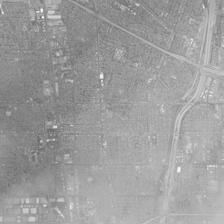

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [ ]:
img = cv2.imread(paths[15], 0)
cv2_imshow(img)
histr = cv2.calcHist([img],[0],None,[256],[0,256])
histr.flatten()[0:30]

In [ ]:
g_freq = np.empty(256)
for j in paths:
  img = cv2.imread(j,0)
  histr = cv2.calcHist([img],[0],None,[256],[0,256])
  #plt.plot(histr, color = col)
  g_freq = np.vstack((g_freq,histr.flatten()))
#plt.xlim([0,256])
#plt.show()

In [ ]:
pd_gfreq = pd.DataFrame(np.round(g_freq[1:,:], 2))
pd_gfreq.columns = ['x.' + str(col + 1) for col in pd_gfreq.columns]
pd_gfreq.head()

,x.1,x.2,x.3,x.4,x.5,x.6,x.7,x.8,x.9,x.10,x.11,x.12,x.13,x.14,x.15,x.16,x.17,x.18,x.19,x.20,x.21,x.22,x.23,x.24,x.25,x.26,x.27,x.28,x.29,x.30,x.31,x.32,x.33,x.34,x.35,x.36,x.37,x.38,x.39,x.40,...,x.217,x.218,x.219,x.220,x.221,x.222,x.223,x.224,x.225,x.226,x.227,x.228,x.229,x.230,x.231,x.232,x.233,x.234,x.235,x.236,x.237,x.238,x.239,x.240,x.241,x.242,x.243,x.244,x.245,x.246,x.247,x.248,x.249,x.250,x.251,x.252,x.253,x.254,x.255,x.256
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,102.0,97.0,130.0,123.0,114.0,111.0,98.0,124.0,110.0,136.0,131.0,172.0,135.0,122.0,120.0,118.0,126.0,103.0,109.0,105.0,100.0,102.0,72.0,83.0,84.0,83.0,66.0,52.0,53.0,65.0,72.0,60.0,44.0,46.0,27.0,25.0,10.0,7.0,3.0,4.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,143.0,140.0,141.0,137.0,152.0,135.0,129.0,140.0,125.0,130.0,126.0,121.0,120.0,130.0,153.0,134.0,116.0,133.0,131.0,132.0,154.0,143.0,153.0,155.0,137.0,149.0,184.0,165.0,177.0,201.0,238.0,239.0,297.0,294.0,369.0,387.0,469.0,479.0,442.0,1434.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,27.0,15.0,15.0,20.0,29.0,20.0,23.0,29.0,18.0,24.0,21.0,29.0,22.0,23.0,13.0,26.0,28.0,22.0,16.0,12.0,16.0,14.0,16.0,26.0,6.0,13.0,12.0,10.0,4.0,11.0,5.0,10.0,13.0,9.0,7.0,6.0,5.0,5.0,4.0,35.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,141.0,122.0,112.0,89.0,106.0,99.0,98.0,91.0,88.0,95.0,74.0,67.0,66.0,65.0,54.0,64.0,70.0,49.0,64.0,53.0,51.0,52.0,54.0,38.0,60.0,62.0,46.0,37.0,32.0,29.0,17.0,5.0,6.0,7.0,12.0,3.0,6.0,3.0,1.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,20.0,22.0,10.0,14.0,19.0,20.0,12.0,15.0,10.0,14.0,16.0,10.0,13.0,6.0,4.0,5.0,6.0,5.0,7.0,7.0,6.0,4.0,4.0,1.0,7.0,8.0,7.0,4.0,1.0,2.0,4.0,0.0,1.0,1.0,1.0,3.0,1.0,1.0,0.0,2.0


In [ ]:
df = pd.concat([label_file["AQI_class"], pd_gfreq], axis=1)

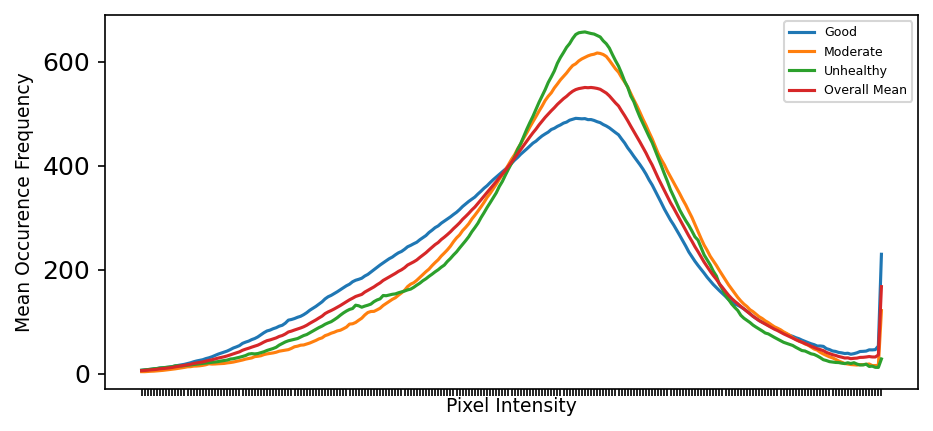

In [83]:
fig, ax = plt.subplots(figsize=(7, 3.3), dpi=150)
for l in label:
  plt.plot(df[(df['AQI_class'] == l)].iloc[:,14:].mean(axis =  0), label=l)
plt.plot(df.iloc[:,14:].mean(axis =  0), label = "Overall Mean")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
ax = plt.gca()
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='major',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)
ax.set_xlabel('Pixel Intensity', fontsize=9)
ax.set_ylabel('Mean Occurence Frequency',  fontsize=9)
ax.legend(loc='upper right', prop={'size': 6})
plt.show()

In [ ]:
# Save the df for later
df.to_csv(experiments_dir + "/frequencies_grayscale.csv")

## Pre-Processing

In [63]:
df = pd.read_csv(experiments_dir + '/frequencies_grayscale.csv')
df = df.drop("Unnamed: 0", axis=1)

In [10]:
def error_rate(y_true, y_pred):
    return 1 - accuracy_score(y_true, y_pred)

In [11]:
encode = {"AQI_class": {"Good": 1, "Moderate" : 2, "Unhealthy" : 3}}
df.replace(encode, inplace = True)

In [12]:
df.head()

,AQI_class,x.1,x.2,x.3,x.4,x.5,x.6,x.7,x.8,x.9,x.10,x.11,x.12,x.13,x.14,x.15,x.16,x.17,x.18,x.19,x.20,x.21,x.22,x.23,x.24,x.25,x.26,x.27,x.28,x.29,x.30,x.31,x.32,x.33,x.34,x.35,x.36,x.37,x.38,x.39,...,x.217,x.218,x.219,x.220,x.221,x.222,x.223,x.224,x.225,x.226,x.227,x.228,x.229,x.230,x.231,x.232,x.233,x.234,x.235,x.236,x.237,x.238,x.239,x.240,x.241,x.242,x.243,x.244,x.245,x.246,x.247,x.248,x.249,x.250,x.251,x.252,x.253,x.254,x.255,x.256
0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,102.0,97.0,130.0,123.0,114.0,111.0,98.0,124.0,110.0,136.0,131.0,172.0,135.0,122.0,120.0,118.0,126.0,103.0,109.0,105.0,100.0,102.0,72.0,83.0,84.0,83.0,66.0,52.0,53.0,65.0,72.0,60.0,44.0,46.0,27.0,25.0,10.0,7.0,3.0,4.0
1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,143.0,140.0,141.0,137.0,152.0,135.0,129.0,140.0,125.0,130.0,126.0,121.0,120.0,130.0,153.0,134.0,116.0,133.0,131.0,132.0,154.0,143.0,153.0,155.0,137.0,149.0,184.0,165.0,177.0,201.0,238.0,239.0,297.0,294.0,369.0,387.0,469.0,479.0,442.0,1434.0
2,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,27.0,15.0,15.0,20.0,29.0,20.0,23.0,29.0,18.0,24.0,21.0,29.0,22.0,23.0,13.0,26.0,28.0,22.0,16.0,12.0,16.0,14.0,16.0,26.0,6.0,13.0,12.0,10.0,4.0,11.0,5.0,10.0,13.0,9.0,7.0,6.0,5.0,5.0,4.0,35.0
3,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,141.0,122.0,112.0,89.0,106.0,99.0,98.0,91.0,88.0,95.0,74.0,67.0,66.0,65.0,54.0,64.0,70.0,49.0,64.0,53.0,51.0,52.0,54.0,38.0,60.0,62.0,46.0,37.0,32.0,29.0,17.0,5.0,6.0,7.0,12.0,3.0,6.0,3.0,1.0,1.0
4,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,20.0,22.0,10.0,14.0,19.0,20.0,12.0,15.0,10.0,14.0,16.0,10.0,13.0,6.0,4.0,5.0,6.0,5.0,7.0,7.0,6.0,4.0,4.0,1.0,7.0,8.0,7.0,4.0,1.0,2.0,4.0,0.0,1.0,1.0,1.0,3.0,1.0,1.0,0.0,2.0


In [13]:
features = [f'x.{i+1}' for i in range(256)]
target = 'AQI_class'
features[0:5]

['x.1', 'x.2', 'x.3', 'x.4', 'x.5']

In [14]:
X, y = df[features].values, df[target].values
X.shape

(5555, 256)

In [19]:
set_ind = label_file.set
set_ind.iloc[set_ind == "valid"] = "test"
set_ind[0:5]

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


0     test
1    train
2     test
3    train
4    train
Name: set, dtype: object

In [20]:
X_train = X[set_ind == "train"]
X_test = X[set_ind == "test"]
y_train = y[set_ind == "train"]
y_test = y[set_ind == "test"]
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((3333, 256), (3333,), (2222, 256), (2222,))

(0.0, 8000.0)

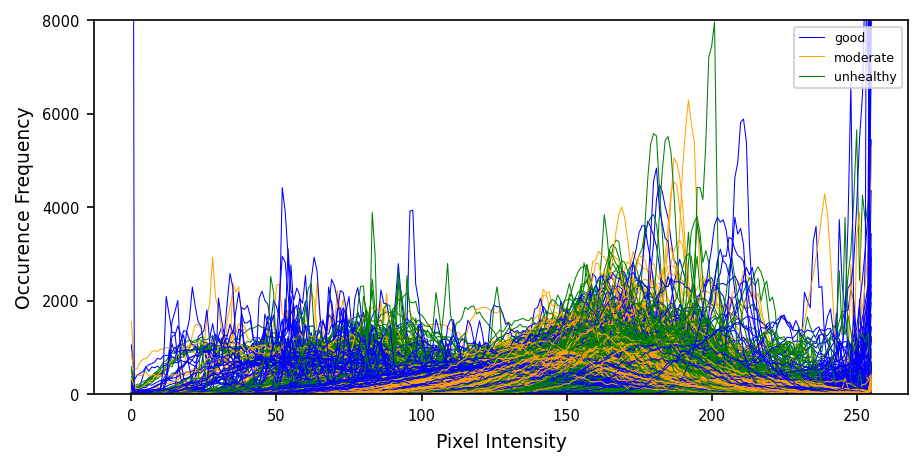

In [82]:
n = 835
good = X[y == 1][:n]
moderate = X[y == 2][:n]
unhealthy = X[y == 3][:n]

fig, ax = plt.subplots(figsize=(7, 3.3), dpi=150)
good_label, moderate_label, unhealthy_label = {'label': 'good'}, {'label': 'moderate'}, {'label': 'unhealthy'}
x_vals = range(256)
for i in range(n):
    ax.plot(x_vals, good[i], linewidth=0.5, color='blue', **good_label)
    ax.plot(x_vals, moderate[i], linewidth=0.5, color='orange', **moderate_label)
    ax.plot(x_vals, unhealthy[i], linewidth=0.5, color= 'green', **unhealthy_label)
    good_label, moderate_label, unhealthy_label = {}, {}, {}
for i in ax.get_yticklabels() + ax.get_xticklabels():
    i.set_fontsize(7)
ax.set_xlabel('Pixel Intensity', fontsize=9)
ax.set_ylabel('Occurence Frequency',  fontsize=9)
ax.legend(loc='upper right', prop={'size': 6})
plt.ylim(0, 8000) 
#_ = ax.text(-14, 27, 'AQI',  fontsize=10)

## Logistic Regression

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

In [27]:
# Plain Logisitic Regression
lr =  SGDClassifier(random_state = 42, loss = 'log', penalty = 'l2', alpha = 1, verbose = False).fit(X_train, y_train)
lr_train_accuracy = accuracy_score(y_train, lr.predict(X_train))
lr_test_accuracy = accuracy_score(y_test, lr.predict(X_test))
print(f'Training Accuracy: {lr_train_accuracy:.3f}')
print(f'    Test Accuracy: {lr_test_accuracy:.3f}')

Training Accuracy: 0.552
    Test Accuracy: 0.541


## Grid Search

In [ ]:
from sklearn.model_selection import GridSearchCV

In [28]:
param_grid = [{'C' : [0.0001, 0.001, 0.01, 0.1]}]
lr_cv = LogisticRegression(solver='lbfgs', max_iter=100000, C=1e43, tol=1e-100, multi_class= 'multinomial')
grid_search = GridSearchCV(lr_cv, param_grid, cv = 3, return_train_score = True)
grid_search.fit(X_train, y_train)

ValueError: ignored

In [ ]:
grid_train_accuracy = accuracy_score(y_train, grid_search.predict(X_train))
grid_test_accuracy = accuracy_score(y_test, grid_search.predict(X_test))
print(f'Training error: {grid_train_accuracy:.3f}')
print(f'    Test error: {grid_test_accuracy:.3f}')

Training error: 0.588
    Test error: 0.521


## Stochastic Gradient Descent

In [29]:
from sklearn.linear_model import SGDClassifier
from collections import Counter
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns

In [30]:
x_mean = X_train.mean(axis = 0, keepdims = True)
x_std = X_train.std(axis = 0, keepdims = True) + 1e-7
X_train_sgd = (X_train - x_mean) / x_std
X_test_sgd = (X_test - x_mean) / x_std

In [31]:
item_ct = Counter(y_train)
max_ct = float(max(item_ct.values()))
class_wts = {class_id: max_ct / num_img for class_id, num_img in item_ct.items()}
no_class_wts = {1: 1, 2: 1, 3: 1}
class_wts

{1: 1.0, 2: 1.800990099009901, 3: 3.609126984126984}

In [52]:
# Default SGD
param_grid = [{'alpha' : [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]}]
sgd_clf = SGDClassifier(random_state = 42, loss = 'log',  penalty = 'l2', verbose = False)
grid_search = GridSearchCV(sgd_clf, param_grid, cv = 3, return_train_score = True)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=SGDClassifier(alpha=0.0001, average=False,
                                     class_weight=None, early_stopping=False,
                                     epsilon=0.1, eta0=0.0, fit_intercept=True,
                                     l1_ratio=0.15, learning_rate='optimal',
                                     loss='log', max_iter=1000,
                                     n_iter_no_change=5, n_jobs=None,
                                     penalty='l2', power_t=0.5, random_state=42,
                                     shuffle=True, tol=0.001,
                                     validation_fraction=0.1, verbose=False,
                                     warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid=[{'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring=None, verbose=0)

In [53]:
grid_search.best_estimator_

SGDClassifier(alpha=0.001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=42, shuffle=True, tol=0.001, validation_fraction=0.1,
              verbose=False, warm_start=False)

In [54]:
sgd_train_accuracy = accuracy_score(y_train, grid_search.predict(X_train))
sgd_test_accuracy = accuracy_score(y_test, grid_search.predict(X_test))
print(f'Training accuracy: {sgd_train_accuracy:.3f}')
print(f'    Test accuracy: {sgd_test_accuracy:.3f}')

Training accuracy: 0.542
    Test accuracy: 0.522


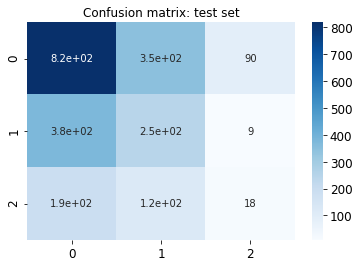

In [51]:
ax = plt.subplot()
test_cf_matrix = confusion_matrix(y_test, grid_search.predict(X_test))
sns.heatmap(test_cf_matrix, annot = True, ax = ax, cmap = 'Blues')
plt.title('Confusion matrix: test set')
plt.show()

## Natural Cubic Spline Code

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from typing import List

class NaturalCubicSplineFeatures(BaseEstimator, TransformerMixin):
    """Generate natural cubic spline and interaction features.
    Parameters
    ----------
    knots :
        Is a list that contains knots list for each feature.
    add_interactions :
        If false, only natural cubic spline features are produced, otherwise
        expanded features interactions are included.
    target_dofs :
        Is a number of degrees of freedom for each feature. If is set, df+1
        knots for features would be automatically calculated at uniform
        quantiles including min and max value of a feature.
    Attributes
    ----------
    dofs_:
        The degrees of freedom for each feature.
    positions_:
        For each feature the index of the first and the last indices of its
        components."""
    def __init__(self, knots: List[List[float]]=None, target_dofs: int=None,
                 add_interactions: bool = False):
        self.knots = knots
        self.add_interactions = add_interactions
        self.target_dofs = target_dofs

    def fit(self, X: np.ndarray,
            y: np.array=None) -> 'NaturalCubicSplineFeatures':
        """Fit NaturalCubicSplineFeatures model according to the given training
           data and parameters.
        Parameters
        ----------
        X :
            Training data.
        y :
            Target values.
        """
        if self.target_dofs is not None:
            quantiles = np.linspace(0, 1, self.target_dofs + 1)
            self.knots = []
            for i in range(X.shape[1]):
                self.knots.append(np.unique(np.quantile(X[:, i], quantiles)))
        # calculate the number of parameters in each component term
        self.dofs_ = np.array([len(k)-1 for k in self.knots])
        # for each feature calculate the first and the last index of expanded
        # basis
        dofs_cumsum = [0] + list(np.cumsum(self.dofs_))
        self.positions_ = [(dofs_cumsum[i-1], dofs_cumsum[i]-1)
                           for i in range(1, len(dofs_cumsum))]
        return self

    def transform(self, X: np.ndarray) -> np.ndarray:
        """Transform data to natural cubic spline basis expansion
        Parameters
        ----------
        X :
            The data to transform, row by row
        Returns
        -------
        X_new : np.ndarray, shape [n_samples, NN]
            The matrix of features, where NN is the number of natural cubic
            spline features generated from the inputs based on knots.
        """
        features_basis_splines = []
        for i in range(X.shape[1]):
            features_basis_splines.append(
                self.__expand_natural_cubic(X[:, i:i+1], self.knots[i]))
        if self.add_interactions:
            self.__add_interaction_features(features_basis_splines)
        return np.hstack(features_basis_splines)

    @staticmethod
    def __dk(X: np.ndarray, knot: float, knot_last: float) -> np.ndarray:
        return (X - knot).clip(0) ** 3 / (knot_last - knot)

    @staticmethod
    def __expand_natural_cubic(X: np.ndarray, knots: np.array) -> np.ndarray:
        basis_splines = [X]
        dk_last = NaturalCubicSplineFeatures.__dk(X, knots[-2], knots[-1])
        for knot in knots[:-2]:
            dk = NaturalCubicSplineFeatures.__dk(X, knot, knots[-1])
            basis_splines.append(dk - dk_last)
        return np.hstack(basis_splines)

    @staticmethod
    def __add_interaction_features(features_basis_splines):
        features_indices = [list(range(expansion.shape[1]))
                            for expansion in features_basis_splines]
        for combination in itertools.product(*features_indices):
            product = features_basis_splines[0][:, combination[0]].copy()
            for i in range(1, len(combination)):
                product *= features_basis_splines[i][:, combination[i]]
            features_basis_splines.append(np.atleast_2d(product).T)

In [ ]:
H = NaturalCubicSplineFeatures(target_dofs=50).fit_transform(np.linspace(1, 256, 256).reshape((256, 1)))
lr = LogisticRegression(solver='liblinear', max_iter=10000000, C=1e42, tol=1e-100)
smoothed_lr = Pipeline(
    [('filter', FunctionTransformer(lambda X: (H.T @ X.T).T, validate=True)),
     ('logistic', lr)]).fit(X_train, y_train)
smoothed_lr_train_error = error_rate(y_train, smoothed_lr.predict(X_train))
smoothed_lr_test_error = error_rate(y_test, smoothed_lr.predict(X_test))
lr_coef_filtered = H @ np.squeeze(lr.coef_)
print(f'Training error: {smoothed_lr_train_error:.3f}')
print(f'    Test error: {smoothed_lr_test_error:.3f}')

Training error: 0.452
    Test error: 0.437
